# Modelling and Evaluation

## Objectives

*   Business requirement 2: 
    * The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

## Inputs

* inputs/cherry-leaves_dataset/cherry-leaves/train
* inputs/cherry-leaves_dataset/cherry-leaves/test
* inputs/cherry-leaves_dataset/cherry-leaves/validation
* Image shape embeddings

## Outputs

* Plot distribution of images across train, validation, and test sets.
* Perform image augmentation.
* Map class indices to alter prediction inference for labels.
* Create and train a machine learning model.
* Save the model.
* Plot learning curves to evaluate model performance.
* Evaluate the model using a pickle file.
* Make predictions on a randomly selected image file.

## Additional Comments

* No additional comments here. 

---


# Set The Data Directory & import libraries

## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Set working directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/pp5-mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/pp5-mildew-detection-in-cherry-leaves'

## Set input directories

Sets the train, test and validation paths

In [5]:
my_data_dir = 'inputs/cherry-leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
valid_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('The old version is already available, please create a new version.')
    pass
else:
    os.makedirs(name=file_path)

The old version is already available, please create a new version.


### Set label names

In [7]:
labels = os.listdir(train_path)
print('The label for the images are:', labels)

The label for the images are: ['healthy', 'powdery_mildew']


## Set image shape

Import saved image shape embedding

In [8]:
import joblib
version = 'v1'
img_shape = joblib.load(filename=f"outputs/{version}/img_shape.pkl")
img_shape

(256, 256, 3)

---

# Number of images in train, test and validation data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




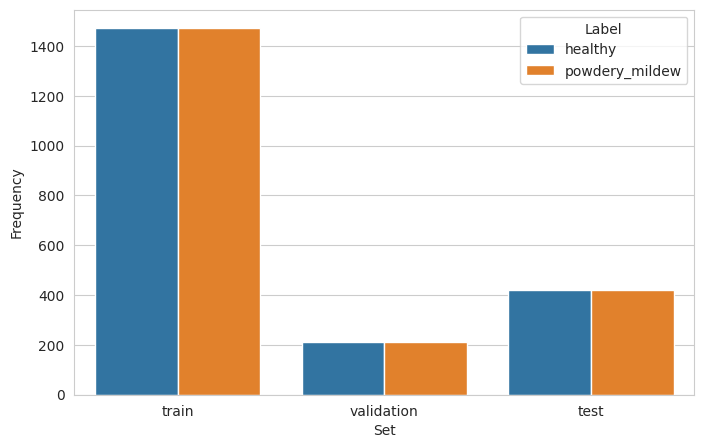

In [9]:
df_img_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_img_freq = df_img_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_img_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/label_dist.png',
            bbox_inches='tight', dpi=150)
plt.show()


---

# Image data augmentation

### Import ImageDataGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* ### Initialize ImageDataGenerator

In [11]:
augmented_img_data = ImageDataGenerator(rotation_range=20,
                                        width_shift_range=0.10,
                                        height_shift_range=0.10,
                                        shear_range=0.1,
                                        zoom_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='nearest',
                                        rescale=1./255
                                        )

* ### Augment the train image dataset

In [12]:
batch_size = 25 
train_set = augmented_img_data.flow_from_directory(train_path, 
                                                    target_size=img_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=True
                                                    )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment the validation image dataset

In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(valid_path,
                                                                        target_size=img_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment the test image dataset

In [15]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=img_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot the augmented training images

(25, 256, 256, 3)


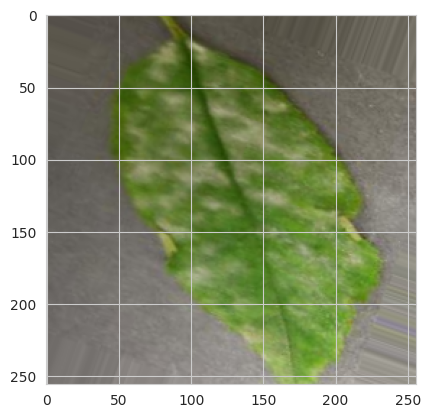

(25, 256, 256, 3)


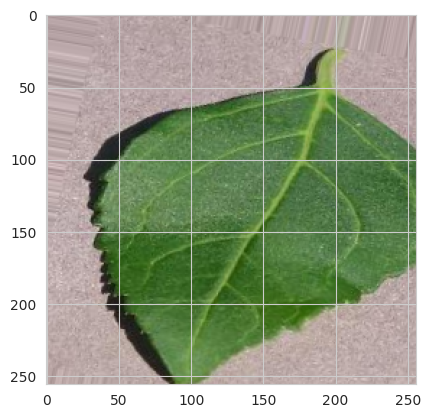

(25, 256, 256, 3)


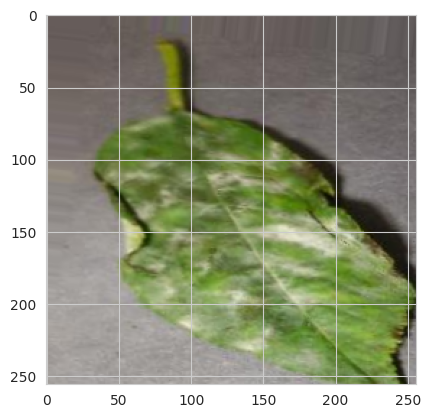

(25, 256, 256, 3)


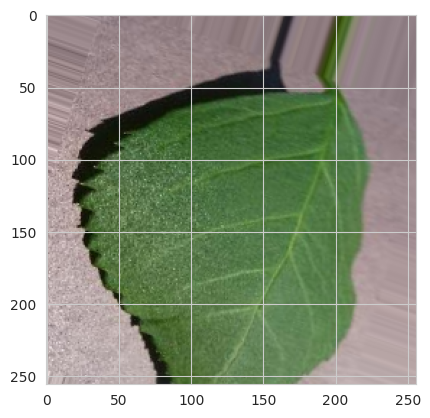

In [18]:
for _ in range(4):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

## Plot the augmented validation and test images

(25, 256, 256, 3)


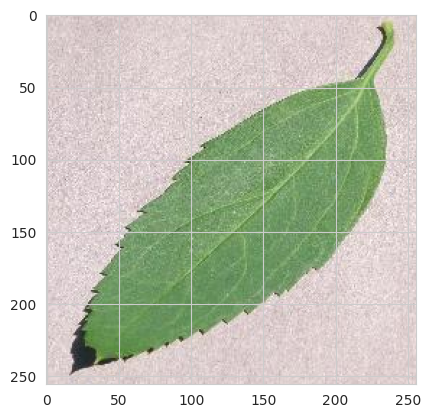

(25, 256, 256, 3)


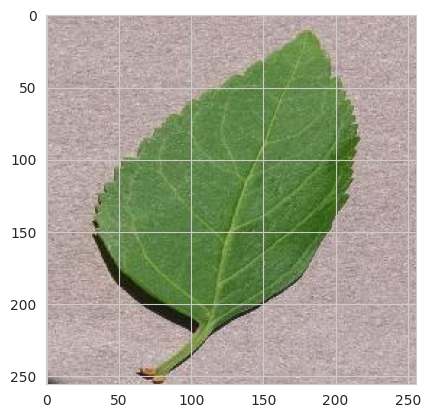

(25, 256, 256, 3)


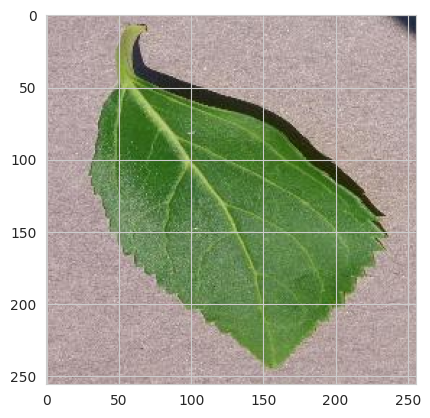

(25, 256, 256, 3)


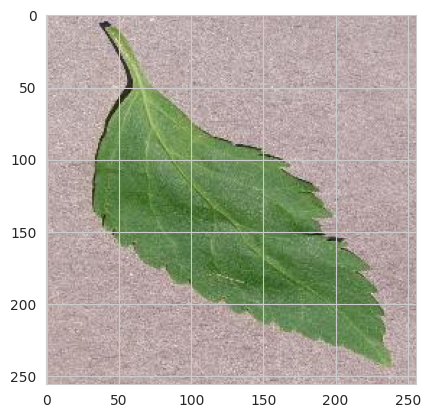

In [19]:
for _ in range(4):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

(25, 256, 256, 3)


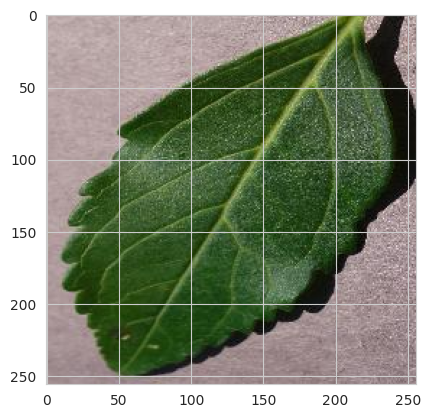

(25, 256, 256, 3)


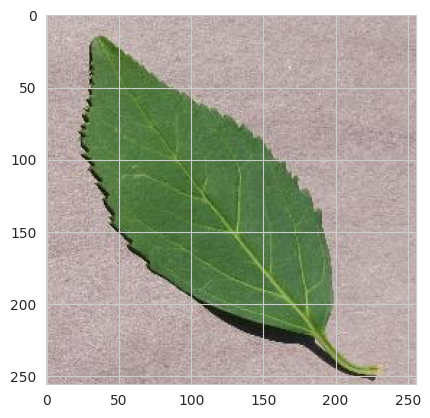

(25, 256, 256, 3)


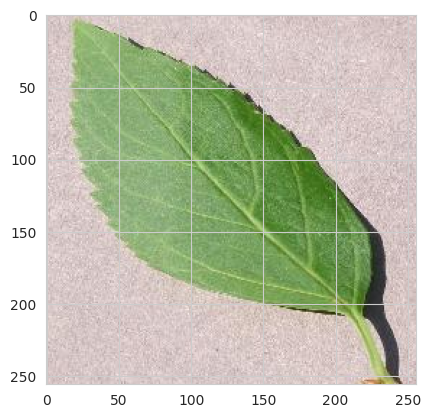

(25, 256, 256, 3)


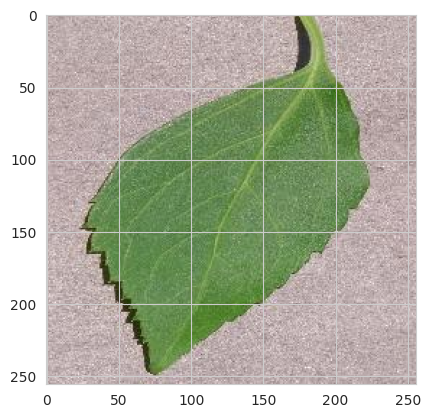

In [20]:
for _ in range(4):
    img, label = test_set.next()
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

## Save the class_indices

In [21]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---